# Analysis of US Coastguard GPS disruption data

## Prerequisites

In [1]:
import pandas as pd
from datetime import datetime as dt

In [4]:
%pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.1 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Webscrape
Run this to webscrape the data to files. If you already have the data locally, skip this section.

### Web scrape GPS interruptions

In [2]:
table_list = pd.read_html(r'https://navcen.uscg.gov/gps-problem-report-status')
table_list[0].to_csv('gps_navcen.csv',index=False)

### Web scrape wikipedia 
#### US state codes

In [2]:
table_list_iso3166= pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-2:US')

In [4]:
US_states_iso3166=table_list_iso3166[0]
US_states_iso3166['clean_state']=US_states_iso3166['Code'].apply(lambda x: x.split('-')[1])
US_states_iso3166.to_csv('US_states_iso3166.csv',index=False)

#### List of sovereign states

In [8]:
sovereign_states_list= pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2')[2]
sovereign_states_list[sovereign_states_list['Country name (using title case)'].notna()].to_csv('sovereign_states.csv',index=False)

## Processing and Analysis

### Load from csv files

In [3]:
gps_disruption_df=pd.read_csv('gps_navcen.csv')
two_letter_codes=pd.read_csv('US_states_iso3166.csv')
sovereign_states=pd.read_csv('sovereign_states.csv')


In [4]:
gps_disruption_df['User']=gps_disruption_df['Description'].apply(lambda x: x.split('NAVCEN')[0])
gps_disruption_df['NAVCEN']=gps_disruption_df['Description'].apply(lambda x: x.split('NAVCEN')[1] if len(x.split('NAVCEN'))>1 else '')

In [5]:
gps_disruption_df

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,User,NAVCEN
0,10/16/2022 14:13:00 CST,Independence,Automobile,USER: My mapping services are constantly searc...,Mapping Issue,10/25/2022,USER: My mapping services are constantly searc...,sent data mapping information.
1,10/06/2022 09:15:00 CST,"Dallas, TX by Southern Methodist University",Other,"USER: For several years now, on and off throug...",Insufficient Information,10/25/2022,"USER: For several years now, on and off throug...",: The GPS Operations Center reviewed the GPS C...
2,09/17/2022 13:00:00 EST,"Navy Yard, Washington DC",None,USER: Our car navigation system and our mobile...,Insufficient Information,10/25/2022,USER: Our car navigation system and our mobile...,: The GPS Operations Center reviewed the GPS C...
3,09/10/2022 09:45:00 CST,Chicago,Automobile,USER: Both my standalone gps and phone gps rep...,Insufficient Information,10/25/2022,USER: Both my standalone gps and phone gps rep...,: The GPS Operations Center reviewed the GPS C...
4,09/07/2022 13:15:00 EST,"I-20 near Columbia, SC",Automobile,"USER: Several times, most recently yesterday, ...",Mapping Issue,09/13/2022,"USER: Several times, most recently yesterday, ...",sent data mapping information.
...,...,...,...,...,...,...,...,...
414,01/05/2017 4:35 UTC,Chile,Law Enforcement,User: There were large spikes in geozone alarm...,User Equipment,05/20/2019,User: There were large spikes in geozone alarm...,: The GPS Operations Center reviewed the GPS C...
415,01/03/2017 11:AM CST,San Angelo Airport,Aviation,User: The GPS systems in normal mode not milit...,Unintentional Interference,05/20/2019,User: The GPS systems in normal mode not milit...,: Report referred to FCC. FCC conducted an inv...
416,01/02/2017 3:00 EST,North Carolina - South Carolina border,Transportation,User: GPS would say when you plug in that ther...,User Equipment,05/20/2019,User: GPS would say when you plug in that ther...,: The GPS Operations Center reviewed the GPS C...
417,01/01/2017 12:00 EST,"Elizabeth, NJ",Transportation,"User: My business is located in Elizabeth, NJ....",Mapping Issue,05/20/2019,"User: My business is located in Elizabeth, NJ....",: User provided information on how to contact ...


## Analyse disruptions by date

In [6]:
gps_disruption_df['local_date']=gps_disruption_df['Disruption Date/Time']\
.apply(lambda x:dt.strptime(x[0:10],'%m/%d/%Y'))

The local date is the UTC date with up to 0.5 day error. That's not bad for analysis to the nearest day. This will have to be improved for more precise analysis.

<AxesSubplot: xlabel='local_date'>

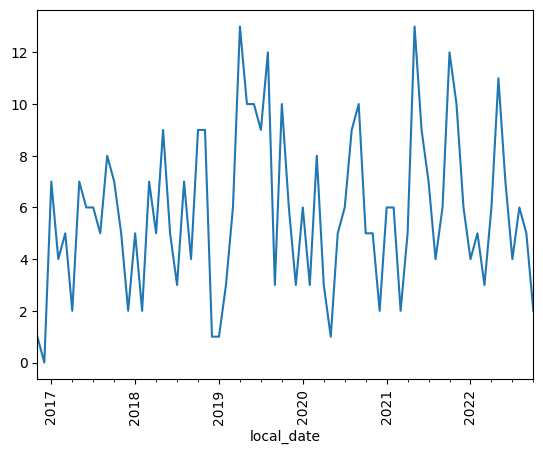

In [7]:
gps_disruption_df.resample('M', on='local_date').\
count()['Disruption Date/Time'].plot(rot=90)


## Analyse disruptions by location

### Add UK to two letter codes

In [8]:
two_letter_codes=\
pd.concat([two_letter_codes,\
           pd.DataFrame({'Code':"UK",'Subdivision name (en)':"United Kingdom",'Subdivision category':"Country",'clean_state':"UK"},index=[two_letter_codes['Code'].count()])])

### Add previous names to ISO list

In [9]:
sovereign_states['previous country name']=\
sovereign_states['Notes']\
.apply(lambda x: str(x)\
       .split('Previous ISO country name: ')[-1]\
       .split('(')[0]\
       .split(';')[0]\
       .split('.')[0]\
       .strip() \
       if 'Previous ISO country name: ' in str(x) \
       else None ) 


In [10]:
sovereign_states['common name']=\
sovereign_states['Notes']\
.apply(lambda x: str(x)\
       .split('common name: ')[-1]\
       .strip()\
       .split(')')[0] \
       if 'common name: ' in str(x) \
       else None )

In [11]:
sovereign_states[sovereign_states['previous country name'].notna()]

,Code,Country name (using title case),Year,ccTLD,Notes,previous country name,common name
27,BN,Brunei Darussalam,1974,.bn,Previous ISO country name: Brunei,Brunei,None
28,BO,Bolivia (Plurinational State of),1974,.bo,Previous ISO country name: Bolivia,Bolivia,None
29,BQ,"Bonaire, Sint Eustatius and Saba",2010,.bq,"Consists of three Caribbean ""special municipal...","Bonaire, Saint Eustatius and Saba BQ previous...",None
46,CM,Cameroon,1974,.cm,"Previous ISO country name: Cameroon, United Re...","Cameroon, United Republic of",None
55,CZ,Czechia,1993,.cz,Previous ISO country name: Czech Republic,Czech Republic,None
65,EH,Western Sahara,1974,NaN,Previous ISO country name: Spanish Sahara (cod...,Spanish Sahara,None
72,FM,Micronesia (Federated States of),1986,.fm,Previous ISO country name: Micronesia,Micronesia,None
76,GB,United Kingdom of Great Britain and Northern I...,1974,.gb (.uk),Includes Akrotiri and Dhekelia (Sovereign Base...,United Kingdom,None
107,IR,Iran (Islamic Republic of),1974,.ir,Previous ISO country name: Iran,Iran,None
116,KH,Cambodia,1974,.kh,Code taken from former name: Khmer Republic P...,"Kampuchea, Democratic",None


In [12]:
sovereign_states[sovereign_states['common name'].notna()]

,Code,Country name (using title case),Year,ccTLD,Notes,previous country name,common name
71,FK,Falkland Islands (Malvinas),1974,.fk,ISO country name follows UN designation due to...,None,Falkland Islands
120,KP,Korea (Democratic People's Republic of),1974,.kp,ISO country name follows UN designation (commo...,None,North Korea
121,KR,"Korea, Republic of",1974,.kr,ISO country name follows UN designation (commo...,None,South Korea
190,RU,Russian Federation,1992,.ru,ISO country name follows UN designation (commo...,None,Russia
227,TW,"Taiwan, Province of China",1974,.tw,Covers the current jurisdiction of the Republi...,None,Taiwan
240,VN,Viet Nam,1974,.vn,ISO country name follows UN designation (commo...,None,South Vietnam


### Clean up Location to get country/code 

In [16]:
def token_search(x_string):
    """ This is a function that matches a US state 2 letter code in the string and returns, or country name and returns, or previous country name and returns, or US state full name and returns"""
    for x_element in x_string.split():
        x_el_stripped=x_element.strip(',').strip(',')
        if x_el_stripped in list(two_letter_codes['clean_state' ]):
            #state_of_interest=two_letter_codes[two_letter_codes['clean_state']==x_el_stripped]
            return x_el_stripped#list(state_of_interest['Subdivision name (en)'].to_dict().values())[0]
    for us_state in list(two_letter_codes['Subdivision name (en)']):
        if us_state.upper() in x_string.upper():
            return  list(two_letter_codes[two_letter_codes['Subdivision name (en)']==us_state]['clean_state'].to_dict().values())[0]
    for sovereign_state in list(sovereign_states['Country name (using title case)']):
        if sovereign_state.upper() in x_string.upper():
            return  list(sovereign_states[sovereign_states['Country name (using title case)']==sovereign_state]['Code'].to_dict().values())[0]
    for sovereign_state in list(sovereign_states[sovereign_states['previous country name'].notna()]['previous country name']):
        if sovereign_state.upper() in x_string.upper():
            return  list(sovereign_states[sovereign_states['previous country name']==sovereign_state]['Code'].to_dict().values())[0]
    for sovereign_state in list(sovereign_states[sovereign_states['common name'].notna()]['common name']):
        if sovereign_state.upper() in x_string.upper():
            return  list(sovereign_states[sovereign_states['common name']==sovereign_state]['Code'].to_dict().values())[0]
gps_disruption_df['matched_location']=gps_disruption_df['Location'].apply(token_search)
gps_disruption_df['matched_location2']=gps_disruption_df[gps_disruption_df['matched_location'].isna()]['User'].apply(token_search)
gps_disruption_df['matched_location']=gps_disruption_df.matched_location.fillna(gps_disruption_df.matched_location2)

### Analyse per country and US state

<AxesSubplot: ylabel='matched_location'>

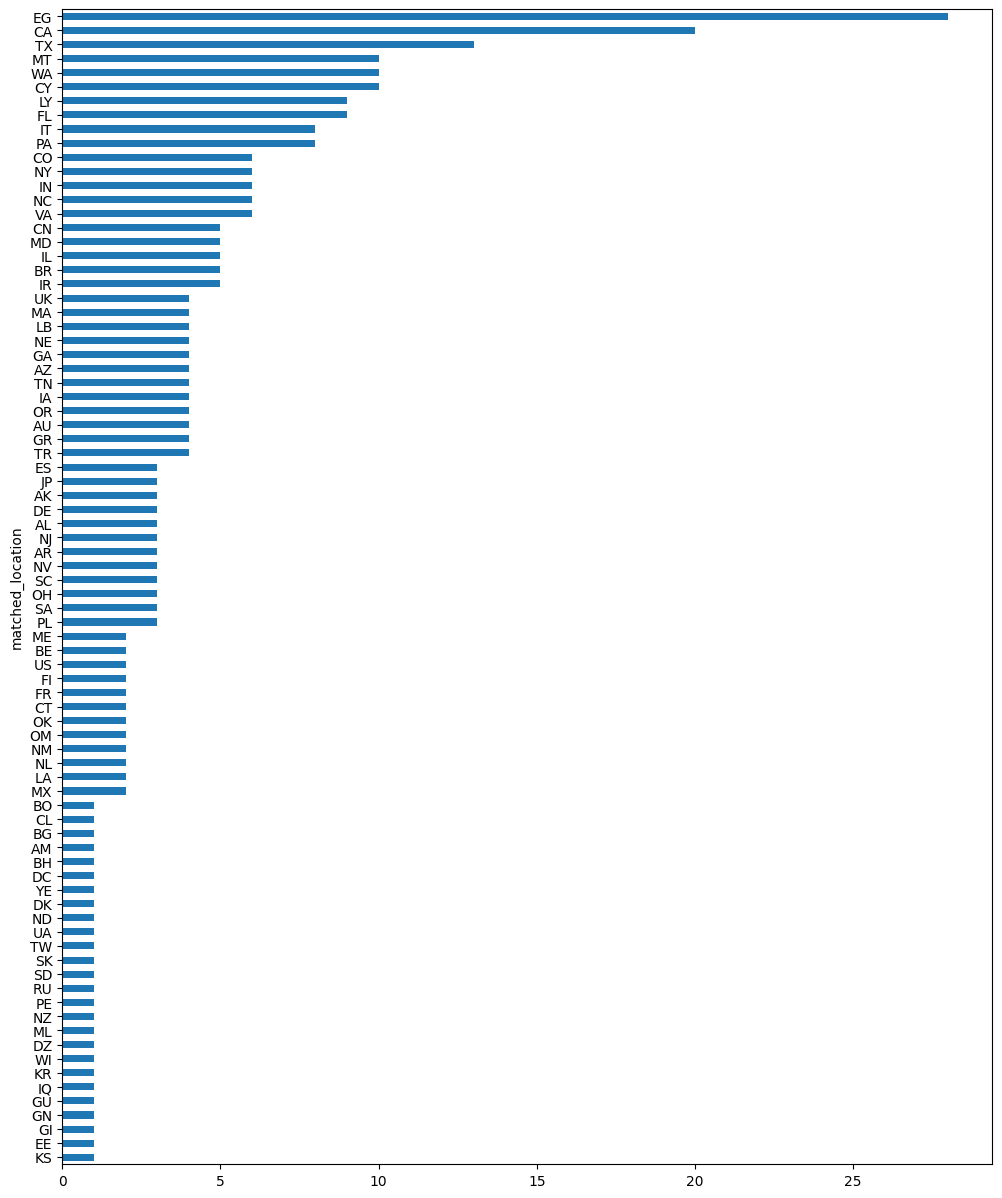

In [17]:
gps_disruption_df[gps_disruption_df['matched_location'].notna()]\
.groupby('matched_location').count()['Disruption Date/Time'].sort_values()\
.plot(kind='barh',figsize=[12,15])

In [18]:
gps_disruption_df['matched_location'].dropna().unique()

array(['KS', 'TX', 'DC', 'SC', 'ME', 'CN', 'GA', 'PA', 'GN', 'CA', 'MA',
       'IA', 'GR', 'NV', 'NE', 'PE', 'OH', 'EG', 'EE', 'MD', 'IQ', 'LY',
       'AZ', 'TR', 'BE', 'IL', 'OR', 'AR', 'SD', 'AU', 'BR', 'FL', 'CY',
       'MT', 'ND', 'AL', 'PL', 'LB', 'UK', 'IT', 'ML', 'TN', 'AK', 'VA',
       'WA', 'GU', 'MX', 'TW', 'BH', 'WI', 'IN', 'NL', 'NC', 'NM', 'IR',
       'CO', 'ES', 'CT', 'SA', 'DK', 'NY', 'NZ', 'BO', 'UA', 'OK', 'OM',
       'FI', 'US', 'YE', 'JP', 'SK', 'BG', 'AM', 'GI', 'DE', 'NJ', 'DZ',
       'KR', 'RU', 'LA', 'FR', 'CL'], dtype=object)

In [19]:
gps_disruption_df[gps_disruption_df['matched_location']=='CA']

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,User,NAVCEN,local_date,matched_location,matched_location2
11,08/15/2022 18:00:00 PST,"Santa Clara, California. West of Bracher Park",Transportation,USER: I go buy a specific block in my neighbor...,Insufficient Information,10/25/2022,USER: I go buy a specific block in my neighbor...,: The GPS Operations Center reviewed the GPS C...,2022-08-15,CA,NaN
14,07/22/2022 11:30:00 PST,"Fontana, CA",Automobile,USER: Google maps and Garmin satellite recepti...,Insufficient Information,08/23/2022,USER: Google maps and Garmin satellite recepti...,: The GPS Operations Center reviewed the GPS C...,2022-07-22,CA,NaN
40,04/10/2022 13:37 PST,"San Diego, CA (Fasihion Valley Mall area",Automobile,USER: GPS on automobile was not working from a...,User Equipment,05/04/2022,USER: GPS on automobile was not working from a...,: Spoke to the reporting source and determined...,2022-04-10,CA,NaN
69,10/28/2021 05:00 EST,"San Diego CA, Providence RI, Baton Rouge LA",Timing,USER: We have GPS clocks deployed across the U...,Other,02/09/2022,USER: We have GPS clocks deployed across the U...,: The GPS Operations Center reviewed the GPS C...,2021-10-28,CA,NaN
112,05/14/2021 1400 PST,"Lompoc, CA",NaN,"USER: Was going to the beach, could not acquir...",Insufficient Information,05/27/2021,"USER: Was going to the beach, could not acquir...",: The GPS Operations Center reviewed the GPS C...,2021-05-14,CA,NaN
125,03/17/2021 12 PST,California,Other,My GPS keeps going in and out saying satellite...,Insufficient Information,05/03/2021,My GPS keeps going in and out saying satellite...,: The GPS Operations Center reviewed the GPS C...,2021-03-17,CA,NaN
144,11/15/2020 2300 PST,"Pacifica, CA",Marine,User: While conducting a search near Pacifica ...,Insufficient Information,12/15/2020,User: While conducting a search near Pacifica ...,: The GPS Operations Center reviewed the GPS C...,2020-11-15,CA,NaN
201,01/01/2020 19:00 PST,"Lancaster CA, Hwy CA-14 crossing Ave J",Transportation,"User: This location, on CA-14 northbound cross...",Insufficient Information,07/30/2020,"User: This location, on CA-14 northbound cross...",: The GPS Operations Center reviewed the GPS C...,2020-01-01,CA,NaN
255,05/30/2019 23:09 UTC,"Tokyo, Japan. Santa Rosa, CA",Timing,The receiver logged anomalous time of week bei...,User Equipment,09/11/2019,The receiver logged anomalous time of week bei...,: The GPS Operations Center reviewed the GPS C...,2019-05-30,CA,NaN
256,05/23/2019 9:30 PST,"San Mateo, CA to Palo Alto, CA",Automobile,User: Both built-in and mobile phone GPS indic...,User Equipment,06/10/2019,User: Both built-in and mobile phone GPS indic...,: The GPS Operations Center reviewed the GPS C...,2019-05-23,CA,NaN


In [20]:
gps_disruption_df[gps_disruption_df['Location']=='Channel Islands, CA']['Description'].to_dict()

{401: 'User: Several systems, across all of our assets at sea, all affected NAVCEN: The GPS Operations Center reviewed the GPS Constellation and Control Segment, there are no known anomalies that might affect GPS signal integrity at the time and vicinity of the reported outage. Space Weather was reviewed and found unlikely to have impacted GPS performance. No correlating reports from other users or interagency partners. Authorized GPS testing was scheduled within 200 miles of the reported location and may have impacted GPS performance.'}

There is such a thing as https://en.wikipedia.org/wiki/Channel_Islands_(California)

In [21]:
gps_disruption_df[gps_disruption_df['matched_location']=='GA']

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,User,NAVCEN,local_date,matched_location,matched_location2
8,08/18/2022 10:30:00 EST,Cartersville Georgia,Transportation,USER: Tractor trailers on coming in a resident...,Mapping Issue,08/23/2022,USER: Tractor trailers on coming in a resident...,sent data mapping information to report unaut...,2022-08-18,GA,NaN
147,10/20/2020 11:00 am EST,Stockbridge and McDonough GA,Transportation,"User: Kept reporting ""GPS Network Unavailable""...",Insufficient Information,10/27/2020,"User: Kept reporting ""GPS Network Unavailable""...",: The GPS Operations Center reviewed the GPS C...,2020-10-20,GA,NaN
366,10/10/2017 0920 EST,"Macon, GA",Other,User: GPS unit could not ﬁx any satellites unt...,User Equipment,05/20/2019,User: GPS unit could not ﬁx any satellites unt...,: The GPS Operations Center reviewed the GPS C...,2017-10-10,GA,NaN
405,03/04/2017 2015 EST,"Lyons, GA",Transportation,User: Our home is located on the west side of ...,Mapping Issue,05/20/2019,User: Our home is located on the west side of ...,: User provided information on how to contact ...,2017-03-04,GA,NaN


<AxesSubplot: ylabel='matched_location2'>

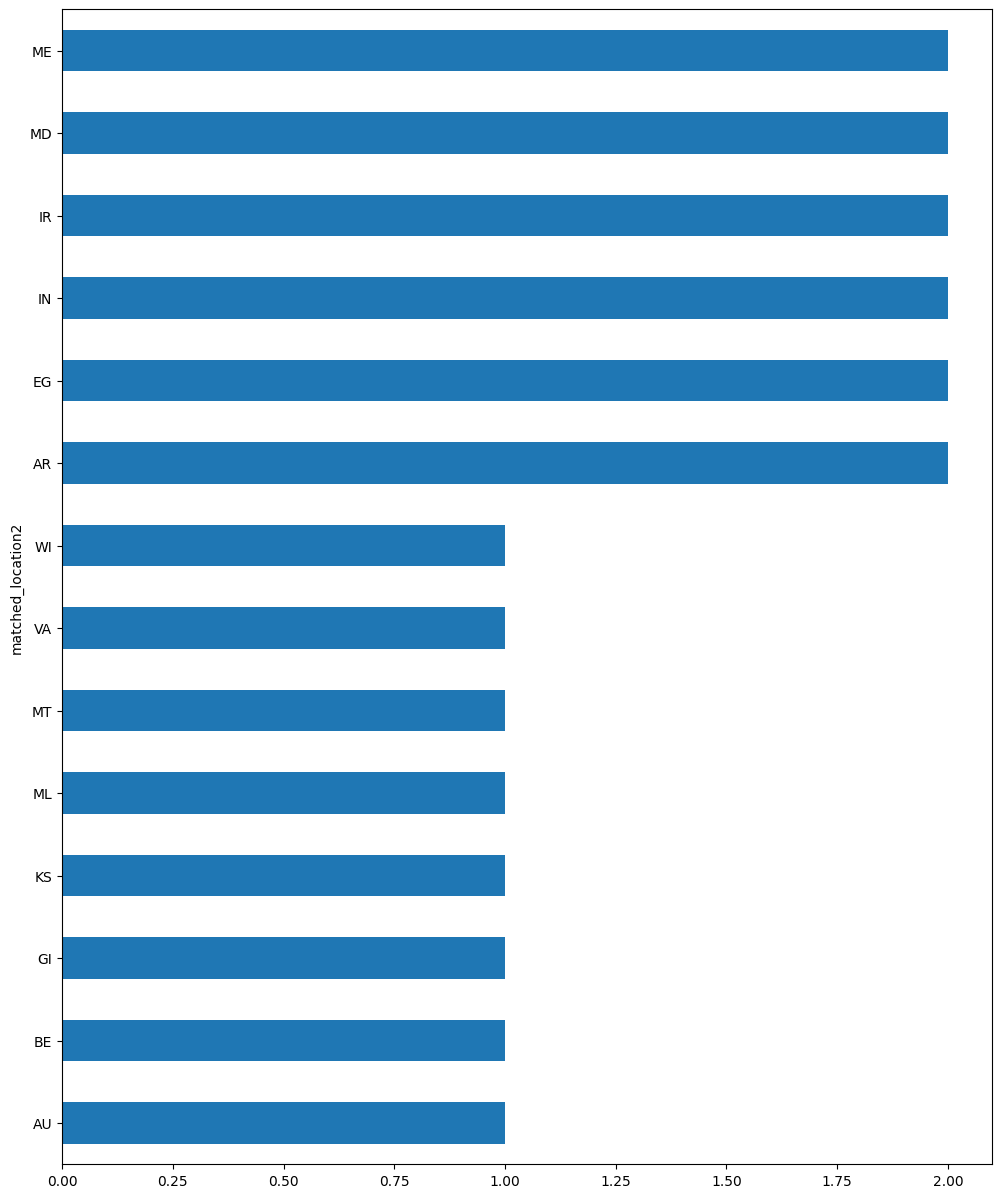

In [22]:
gps_disruption_df[gps_disruption_df['matched_location2'].notna()]\
.groupby('matched_location2').count()['Disruption Date/Time'].sort_values()\
.plot(kind='barh',figsize=[12,15])

In [23]:
gps_disruption_df[gps_disruption_df['matched_location2']=='IN']

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,User,NAVCEN,local_date,matched_location,matched_location2
176,06/17/2020 0415 Brazil Eastern Time,Sao Marcos Bay area,Marine,"User: ON 17TH JUNE 20 AT 0415LT""NO FIX ERROR"" ...",Unknown Interference,07/30/2020,"User: ON 17TH JUNE 20 AT 0415LT""NO FIX ERROR"" ...",: The GPS Operations Center reviewed the GPS C...,2020-06-17,IN,IN
337,04/18/2018 08:00 GMT,EASTERN MEDITERRANEAN SEA,Marine,"User: DISRUPTIONS EVERY FEW MINUTES, CONTINUIN...",Unknown Interference,05/07/2019,"User: DISRUPTIONS EVERY FEW MINUTES, CONTINUIN...",: See U.S. Maritime Advisory concerning GPS In...,2018-04-18,IN,IN


In [24]:
gps_disruption_df[gps_disruption_df['matched_location']=='IN']

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,User,NAVCEN,local_date,matched_location,matched_location2
139,12/21/2020 12:40 India Standard Time,"Luvkushnagar(Laundi), India",Transportation,USER: Tried many phones but GPS location is no...,Insufficient Information,01/21/2021,USER: Tried many phones but GPS location is no...,: The GPS Operations Center reviewed the GPS C...,2020-12-21,IN,NaN
165,08/21/2020 5:30 India Standard Time,"Darjeeling, India",Timing,User indicated an intermittent problem that wa...,Unknown Interference,09/10/2020,User indicated an intermittent problem that wa...,: The GPS Operations Center reviewed the GPS C...,2020-08-21,IN,NaN
176,06/17/2020 0415 Brazil Eastern Time,Sao Marcos Bay area,Marine,"User: ON 17TH JUNE 20 AT 0415LT""NO FIX ERROR"" ...",Unknown Interference,07/30/2020,"User: ON 17TH JUNE 20 AT 0415LT""NO FIX ERROR"" ...",: The GPS Operations Center reviewed the GPS C...,2020-06-17,IN,IN
293,11/10/2018 09:00 CST,"Evansville, IN",First Responder,User: On 22 October the units began reporting ...,User Equipment,05/08/2019,User: On 22 October the units began reporting ...,: The GPS week number for both dates are the s...,2018-11-10,IN,NaN
316,08/03/2018 11:30 EST,"Avon, IN",Other,User: My son wears a GPS watch due to the poss...,User Equipment,05/07/2019,User: My son wears a GPS watch due to the poss...,: The GPS Operations Center reviewed the GPS C...,2018-08-03,IN,NaN
337,04/18/2018 08:00 GMT,EASTERN MEDITERRANEAN SEA,Marine,"User: DISRUPTIONS EVERY FEW MINUTES, CONTINUIN...",Unknown Interference,05/07/2019,"User: DISRUPTIONS EVERY FEW MINUTES, CONTINUIN...",: See U.S. Maritime Advisory concerning GPS In...,2018-04-18,IN,IN


### Unmatched location needs cleaning

In [25]:
disruptions_by_location=gps_disruption_df[gps_disruption_df['matched_location'].isna()].groupby('Location').count()['Disruption Date/Time']


In [26]:
disruptions_by_location[disruptions_by_location>1].sort_values(ascending=False)#.plot(kind='barh')

Location
Limassol                  6
Global                    3
East Mediterranean Sea    2
Istanbul                  2
Mediterranean Sea         2
Shanghai, PRC             2
Suez Canal                2
Worldwide                 2
Name: Disruption Date/Time, dtype: int64

<AxesSubplot: ylabel='Location'>

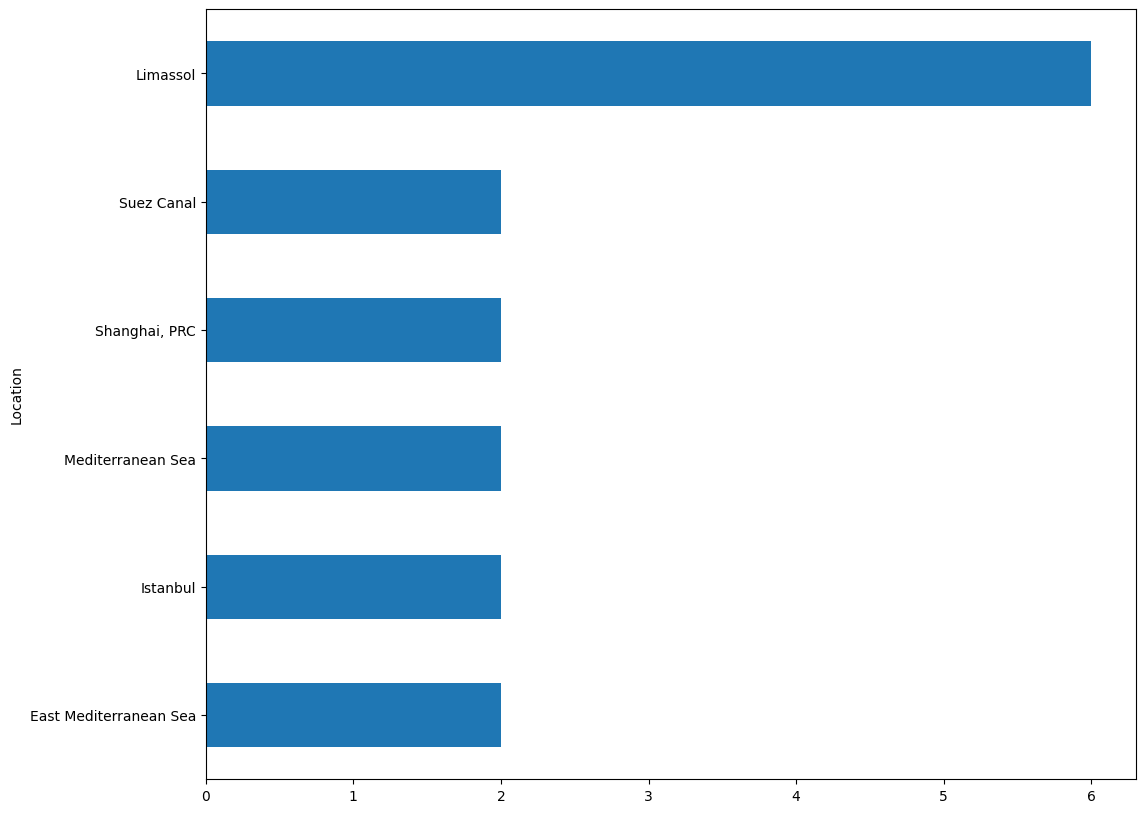

In [27]:
disruptions_by_location[disruptions_by_location>1 ].drop(['Worldwide','Global']).sort_values()\
.plot(kind='barh',figsize=[12,10])

In [28]:
gps_disruption_df.query('Location in ("Worldwide","Global","At sea")')[['local_date','Location','Description','Cause','matched_location']]

,local_date,Location,Description,Cause,matched_location
91,2021-07-28,At sea,USER: The vessel was sailing towards port said...,Unknown Interference,None
138,2021-01-16,Global,CNES has detected a repetition of IODE for PRN...,IODC_10-Bit,None
169,2020-08-04,Global,User: CNES (Centre National d Etudes Spatiales...,ICD_Violation,None
195,2020-02-12,Worldwide,"User: In February 2020 (Feb 12th, 13th, 15th a...",ICD_Violation,None
286,2019-02-01,Global,User: Thanks to Navigation and Timing Monitori...,None,None
356,2017-11-30,Global,User: GPS PRN22 orbit error started to wander ...,User Equipment,AU
372,2017-09-20,Worldwide,User: It appears that the Subframe-2 IODC mess...,User Equipment,None


In [29]:
gps_disruption_df.query('Location=="United States"')[['Description','matched_location']]

,Description,matched_location
277,At roughly 8:45 PM CST lost GPS Sync to variou...,US
287,User: Observation of GPS NANU times in relatio...,US


In [30]:
for description_str in gps_disruption_df.query('Location=="United States"')['Description']:
    print(description_str)

At roughly 8:45 PM CST lost GPS Sync to various cell sites around the US. The common GPS is trend is dual cones feeding sync to UMTS and LTE technologies. To mitigate the issue Field Technicians have removed one of the GPS cones and have a master sync from LTE feeding UMTS. There was no back office or architectural changes to our network during this time that would have caused this failure. We are curious if there were any changes made in preparation of the GPS System rollover slated for tomorrow April 6th that may have affected the base stations to lose sync. NAVCEN: The U.S. Air Force points to Interface Specification IS-GPS-200, paragraph 20.3.3.5.2.2, Almanac Reference Time, which states: "The almanac reference time, t(oa), is some some multiple of 2(12) seconds occurring approximately 70 hours after the first valid transmission time for this almanac data set (reference 20.3.4.5). The almanac is updated often enough to ensure that GPS time, t, shall differ from t(oa) by less than 3

In [31]:
gps_disruption_df.query('Location in ("Mediterranean Sea","Eastern Mediterranean","East Mediterranean Sea")')\
[['Description','matched_location','matched_location2','NAVCEN']]

,Description,matched_location,matched_location2,NAVCEN
110,User indicated an intermittent problem that wa...,None,None,: The GPS Operations Center reviewed the GPS C...
120,USER: roughly 12 hours of gps spoofing upon de...,EG,EG,: The GPS Operations Center reviewed the GPS C...
123,Lost GPS signal for six-minutes from 1620 GMT ...,None,None,: The GPS Operations Center reviewed the GPS C...
124,"GPS jamming begins, affecting both GPS units. ...",None,None,: The GPS Operations Center reviewed the GPS C...
152,User: Additional vessel in area were experienc...,None,None,: The GPS Operations Center reviewed the GPS C...
154,User: Intermittent GPS signal beginning at 013...,None,None,: The GPS Operations Center reviewed the GPS C...


In [32]:
for description_str in gps_disruption_df.query('Location in ("Mediterranean Sea","Eastern Mediterranean","East Mediterranean Sea")')\
['Description']:
    print(description_str)

User indicated an intermittent problem that was otherwise unspecified. NAVCEN: The GPS Operations Center reviewed the GPS Constellation and Control Segment, there are no known anomalies that might affect GPS signal integrity at the time and vicinity of the reported problem. Space weather was reviewed and found unlikely to have impacted GPS performance. There were no authorized GPS tests in the area. No correlating reports from interagency partners. The report of interference is similar to that outlined by U.S. Maritime Administration in Maritime Advisory 2021-004-Various GPS Interference. User encouraged to report the issue to the nearest communication authority.
USER: roughly 12 hours of gps spoofing upon departure from port Said Egypt. GPS signal rapidly shifted numerous times, position 6-8 miles off. Position dropped for 90 percent of the 12 hours. GPS aboard connected to ECDIS, RADAR,AIS, GYRO repeater panel, GMDSS suite. NAVCEN: The GPS Operations Center reviewed the GPS Constella

### Rare locations

In [33]:
disruptions_by_location[disruptions_by_location==1 ]

Location
100NM off Port Said                     1
35 - 04.4N, 034 - 48.1E                 1
AT SEA                                  1
Abu Musa Island                         1
At sea                                  1
                                       ..
city of belmont                         1
juaymah Terminal                        1
many US locations                       1
tehran                                  1
transiting inside Suez Canal N-bound    1
Name: Disruption Date/Time, Length: 84, dtype: int64

### quantify scale of each subgroup

In [34]:
gps_disruption_df['matched_location'].nunique()

82

In [35]:
gps_disruption_df[gps_disruption_df['matched_location'].notna()]['Disruption Date/Time'].count()

314

In [36]:
disruptions_by_location[disruptions_by_location>1 ].count()

8

In [37]:
disruptions_by_location[disruptions_by_location==1 ].count()

84